In [2]:
from torchsummary import summary
from tqdm import tqdm
import torch.nn as nn
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from src.nn.mrw_dataset import MRWDataset
from src.nn.to_tensor import ToTensor
from src.nn.create_data_loaders import create_data_loaders
from src.nn.cnn_regressor import CNNRegressor
from src.nn.archs import CNN_C1, CNN_C2, CNN_L, CNN_EPSILON
from src.nn.plot_losses import plot_losses
from src.nn.get_all_predictions import get_all_predictions
from src.nn.analyse_predictions import analyse_predictions
from src.nn.plot_predictions import plot_predictions
import src.ctes.num_ctes as nctes
import src.ctes.str_ctes as sctes
import src.ctes.path_ctes as pctes

In [3]:
data_path = pctes.DATAPATH
timestamp = "2024_01_12__18_33_49"
arch_name = "CNN_C1"
hyperparams_path = f"../../data/hyperparams_{arch_name}_{timestamp}.npz"
model_path = f"../../data/model_{arch_name}_{timestamp}.pt"
losses_path = f"../../data/losses_{arch_name}_{timestamp}.npz"
losses_img_path = f"../../data/losses_{arch_name}_{timestamp}.png"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [5]:
hyperparams = np.load(hyperparams_path)
print(hyperparams)

NpzFile '../../data/hyperparams_CNN_C1_2024_01_12__18_33_49.npz' with keys: len, test_size, valid_size, epochs, batch_size...


In [6]:
seed = int(hyperparams[sctes.SEED])
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [7]:
sample_size = nctes.LEN_SAMPLE
model = CNN_C1(input_size=sample_size, dropout_probs=hyperparams[sctes.DROPOUT_PROBS])
model.to(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Dropout: 1-2                           [-1, 16, 32768]           --
├─Sequential: 1-3                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-4                         [-1, 32, 16384]           --
├─Dropout: 1-5                           [-1, 32, 16384]           --
├─Sequential: 1-6                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─Ba

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Dropout: 1-2                           [-1, 16, 32768]           --
├─Sequential: 1-3                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-4                         [-1, 32, 16384]           --
├─Dropout: 1-5                           [-1, 32, 16384]           --
├─Sequential: 1-6                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─Ba

In [8]:
transform = ToTensor()
labels    = hyperparams[sctes.LABELS]

data      = MRWDataset(data_path, transform, sample_size, labels)

In [9]:
batch_size = int(hyperparams[sctes.BATCH_SIZE])
valid_size = float(hyperparams[sctes.VALID_SIZE])
test_size = float(hyperparams[sctes.TEST_SIZE])

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [10]:
losses = np.load(losses_path)
train_losses = losses[sctes.TRAIN]
valid_losses = losses[sctes.VAL]

In [11]:
criterion = nn.MSELoss()
print(f"{criterion = }")

criterion = MSELoss()


In [12]:
data_len = int(hyperparams[sctes.LEN])
test_len = int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])
valid_len = int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE])
train_len = data_len - test_len - valid_len

if sctes.MODEL_NAME in hyperparams :
    print(f"Model name       = {hyperparams[sctes.MODEL_NAME]}")
print(f"Sample length    = {nctes.LEN_SAMPLE}")
print(f"Total samples    = {data_len}")
print(f"Train samples    = {train_len}")
print(f"Valid samples    = {valid_len}")
print(f"Test samples     = {test_len}")
print(f"Batch size       = {int(hyperparams[sctes.BATCH_SIZE])}")
print(f"Number of epochs = {int(hyperparams[sctes.EPOCHS])}")
print(f"Loss             = {''.join(hyperparams[sctes.CRITERION].tolist())}")
print(f"Optimizer        = {''.join(hyperparams[sctes.OPTIMIZER].tolist())}")
print(f"Learning rate    = {float(hyperparams[sctes.LR])}")
print(f"Seed             = {float(hyperparams[sctes.SEED])}")
if sctes.DROPOUT_PROBS in hyperparams:
    print(f"Dropout probas    = {(hyperparams[sctes.DROPOUT_PROBS].tolist())}")
print(f"Labels           = {hyperparams[sctes.LABELS]}")

Model name       = Variable dropout probas and L2 regularization
Sample length    = 32768
Total samples    = 12800
Train samples    = 8192
Valid samples    = 2048
Test samples     = 2560
Batch size       = 6
Number of epochs = 2
Loss             = MSELoss()
Optimizer        = Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
Learning rate    = 0.001
Seed             = 42.0
Dropout probas    = [0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7]
Labels           = ['c1']


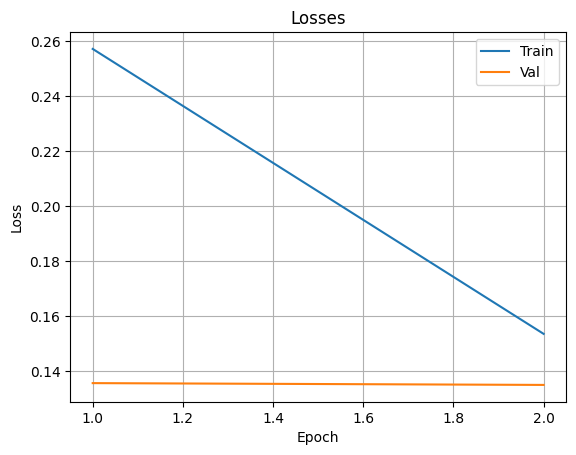

In [13]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])
# plt.savefig(losses_img_path)

In [14]:
targets, preds, output_losses  = get_all_predictions(model, test_loader, device, criterion, labels)

100%|██████████| 427/427 [00:17<00:00, 24.95it/s]


In [15]:
analyse_predictions(targets, preds)

True values of c1 and their count : 
0.0: 665 occurrences
0.3333333432674408: 625 occurrences
0.6666666865348816: 635 occurrences
1.0: 635 occurrences

Predicted values of c1 and their count: 
0.48990702629089355: 1 occurrences
0.4904737174510956: 1 occurrences
0.49099820852279663: 1 occurrences
0.49106860160827637: 1 occurrences
0.49112600088119507: 1 occurrences
0.49128425121307373: 1 occurrences
0.4914167523384094: 1 occurrences
0.4915165305137634: 1 occurrences
0.4916258454322815: 1 occurrences
0.49171319603919983: 1 occurrences
0.4917418956756592: 1 occurrences
0.491760790348053: 1 occurrences
0.49176621437072754: 1 occurrences
0.4917788803577423: 1 occurrences
0.49178892374038696: 1 occurrences
0.49179601669311523: 1 occurrences
0.4917965233325958: 1 occurrences
0.4917985796928406: 1 occurrences
0.4918007552623749: 1 occurrences
0.49180084466934204: 1 occurrences
0.49180111289024353: 1 occurrences
0.49180173873901367: 1 occurrences
0.4918019771575928: 1 occurrences
0.491802215576

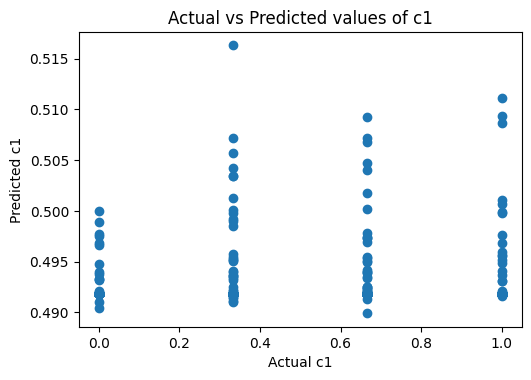

In [16]:
plot_predictions(targets, preds, labels)

In [17]:
test_losses = [] 
for target, pred in tqdm(zip(targets, preds)):
    target = torch.FloatTensor(target).to(device=device)
    pred = torch.FloatTensor(pred).to(device=device)
    test_losses.append(criterion(target, pred).item())
test_losses = np.array(test_losses)

2560it [00:00, 7836.51it/s]


In [18]:
idx_sort    = np.flip(np.argsort(test_losses))
test_losses = test_losses[idx_sort]
targets     = targets[idx_sort]
preds       = preds[idx_sort]

In [19]:
total_test_loss = np.mean(test_losses)
print("Total Test MSE = {:0.4f}".format(total_test_loss))

Total Test MSE = 0.1406


In [20]:
output_labels = {i: label for i, label in enumerate(labels)}
mean_output_losses = {output_labels[i]: np.mean(output_losses[i]) for i in range(len(output_losses))}
print("Test MSE for each output:")
for key, value in mean_output_losses.items():
    print(f"{key}: {value:.4f}")

Test MSE for each output:
c1: 0.1405


In [21]:
n_show = 10
print(f"{n_show} Worst Results ==>")
for i in range(n_show):
    print(f"              c1         c2         L         epsilon")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[i]]}")
    print(f"MSE         = {'{:0.4f}'.format(test_losses[i])}")
    print()

10 Worst Results ==>
              c1         c2         L         epsilon
Target      = ['1.0000']
Prediction  = ['0.4916']
MSE         = 0.2584

              c1         c2         L         epsilon
Target      = ['1.0000']
Prediction  = ['0.4917']
MSE         = 0.2583

              c1         c2         L         epsilon
Target      = ['1.0000']
Prediction  = ['0.4918']
MSE         = 0.2583

              c1         c2         L         epsilon
Target      = ['1.0000']
Prediction  = ['0.4918']
MSE         = 0.2583

              c1         c2         L         epsilon
Target      = ['1.0000']
Prediction  = ['0.4918']
MSE         = 0.2583

              c1         c2         L         epsilon
Target      = ['1.0000']
Prediction  = ['0.4918']
MSE         = 0.2583

              c1         c2         L         epsilon
Target      = ['1.0000']
Prediction  = ['0.4918']
MSE         = 0.2583

              c1         c2         L         epsilon
Target      = ['1.0000']
Prediction  = ['0.

In [28]:
n_show = 10
print(f"{n_show} Best Results ==>")
for i in range(n_show, 0, -1):
    print(f"              {[label + '    ' for label in labels]}")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[-i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[-i]]}")
    print(f"WeightedMSE = {'{:0.4f}'.format(test_losses[-i])}")
    print()

10 Best Results ==>
              ['c1    ']
Target      = ['0.3333']
Prediction  = ['0.4918']
WeightedMSE = 0.0251

              ['c1    ']
Target      = ['0.3333']
Prediction  = ['0.4918']
WeightedMSE = 0.0251

              ['c1    ']
Target      = ['0.3333']
Prediction  = ['0.4918']
WeightedMSE = 0.0251

              ['c1    ']
Target      = ['0.3333']
Prediction  = ['0.4918']
WeightedMSE = 0.0251

              ['c1    ']
Target      = ['0.3333']
Prediction  = ['0.4917']
WeightedMSE = 0.0251

              ['c1    ']
Target      = ['0.3333']
Prediction  = ['0.4915']
WeightedMSE = 0.0250

              ['c1    ']
Target      = ['0.3333']
Prediction  = ['0.4914']
WeightedMSE = 0.0250

              ['c1    ']
Target      = ['0.3333']
Prediction  = ['0.4911']
WeightedMSE = 0.0249

              ['c1    ']
Target      = ['0.3333']
Prediction  = ['0.4911']
WeightedMSE = 0.0249

              ['c1    ']
Target      = ['0.6667']
Prediction  = ['0.5092']
WeightedMSE = 0.0248



In [23]:
# ToDo
 
# On cnn_base.py : 
# Change Flatten layer by some ConvTranspose1d before the linear dense layer